# Online Phase: Indirect Reconstruction

**Aim of this notebook**: This notebook aims to provide a simple example of the online phase of the Indirect Reconstruction (IR) method, proposed by [Introini et al., 2023](https://www.sciencedirect.com/science/article/abs/pii/S0306454922005680). In particular, the case study of buoyancy-driven flow in a square cavity is considered. This algorithm consists of two main steps: firstly, the Parameter Estimation (PE) is performed, and then the Proper Orthogonal Decomposition with Interpolation (POD-I) is applied.

----

*To execute this notebook*: the test snapshots should be placed in `Snapshots`, the magic functions and sensors for the temperature field are saved in `Offline_results`, the POD modes for the other fields should be saved there too and the coefficient maps must have been generated using previous notebook.

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib import cm

from mpi4py import MPI
from dolfinx.io import gmshio
import gmsh
from dolfinx.fem import FunctionSpace
import ufl

from pyforce.tools.backends import LoopProgress
from pyforce.tools.functions_list import FunctionsList
from pyforce.tools.write_read import ImportH5

Let us generate the mesh for importing OpenFOAM dataset into *dolfinx*

In [2]:
mesh_comm = MPI.COMM_WORLD
model_rank = 0

# Initialize the gmsh module
gmsh.initialize()

# Load the .geo file
gmsh.merge('cavity.geo')
gmsh.model.geo.synchronize()

# Set algorithm (adaptive = 1, Frontal-Delaunay = 6)
gmsh.option.setNumber("Mesh.Algorithm", 6)
gdim = 2

# Linear Finite Element
gmsh.model.mesh.generate(gdim)
gmsh.model.mesh.optimize("Netgen")

# Import into dolfinx
model_rank = 0
domain, ct, ft = gmshio.model_to_mesh(gmsh.model, MPI.COMM_WORLD, model_rank, gdim = gdim )
gmsh.finalize()

tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(fdim, tdim)

Info    : Reading 'cavity.geo'...
Info    : Done reading 'cavity.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.00107815s, CPU 0.000847s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Transfinite)
Info    : Done meshing 2D (Wall 0.008234s, CPU 0.006448s)
Info    : 16384 nodes 32770 elements
Info    : Optimizing mesh (Netgen)...
Info    : Done optimizing mesh (Wall 2.792e-06s, CPU 3e-06s)


Let us define the variable names and the functional space onto which the OpenFOAM data have been projected

In [3]:
var_names = ['norm_T', 'p', 'U']
tex_var_names = ['T', 'p', r'\mathbf{u}']

fun_spaces = [FunctionSpace(domain, ('Lagrange', 1)), 
              FunctionSpace(domain, ('Lagrange', 1)), 
              FunctionSpace(domain, ufl.VectorElement("CG", domain.ufl_cell(), 1))]

Let us load the test snapshots

In [4]:
path = './Snapshots/'

test_snaps  = dict()

for field_i, field in enumerate(var_names):
    
    path_snap = path+'TestSet_' +field
    test_snaps[field] = ImportH5(fun_spaces[field_i], path_snap, field)[0]

The temperature is the only one that can be measured

In [5]:
obs_idx = 0

Let us import the GEIM magic functions and sensors and the POD modes for non-observable fields

In [6]:
path_offline = './Offline_results/'

# Magic Functions and Sensors
mf = ImportH5(fun_spaces[obs_idx], path_offline+'BasisFunctions/basisGEIM_'+var_names[obs_idx], 'GEIM_'+var_names[obs_idx])[0]
ms = ImportH5(fun_spaces[obs_idx], path_offline+'BasisSensors/sensorsGEIM_'+var_names[obs_idx], 'GEIM_'+var_names[obs_idx])[0]

# POD modes
pod_modes = dict()
for field_i, field in enumerate(var_names):
    if field_i != obs_idx:
        pod_modes[field] = ImportH5(fun_spaces[field_i], path_offline+'BasisFunctions/basisPOD_'+var_names[field_i], 'POD_'+var_names[field_i])[0]

In the end, let us load the maps of the reduced coefficients

In [7]:
geim_maps = pickle.load(open(path_offline+'maps.geim', 'rb'))
pod_maps  = pickle.load(open(path_offline+'maps.pod', 'rb'))

The snapshots are dependent on two different parameters: the Reynolds and the Richardson number. The test parameters are
\begin{equation*}
Re_{test} = [17.5:10:147.5] \qquad \qquad Ri_{test} = [0.4:0.8:44]
\end{equation*}

In [8]:
dRe = 5.
dRi = 0.4

# Test Parameters
Re_test = np.arange(15+dRe/2,  150+dRe/2, dRe*2)
Ri_test = np.arange(0.2+dRi/2,   5+dRi/2, dRi*2)

Ri, Re = np.meshgrid(Ri_test, Re_test)
mu_test = np.column_stack((Re.flatten(), Ri.flatten()))

## Parameter Estimation

In this section, the measurements of the observable field (temperature in this case) are used to find the characteristic parameter $\boldsymbol{\mu}$, solution of the inverse problem
\begin{equation*}
\boldsymbol{\mu}^\star = \text{arg }\min\limits_{\boldsymbol{\mu}\in\mathcal{D}}
\mathcal{L}_{PE}(\boldsymbol{\mu}) = 
\text{arg }\min\limits_{\boldsymbol{\mu}\in\mathcal{D}}\|\mathbb{B}\boldsymbol{\beta}(\boldsymbol{\mu}) - \mathbf{y}\|_2^2 \qquad\qquad
\text{ given }\mathcal{F}_m(\boldsymbol{\mu}) = \beta_m(\boldsymbol{\mu})
\end{equation*}
with $\mathbb{B}\in\mathbb{R}^{M\times M}$ a lower triangular matrix, whose components are given by the magic function $q_m$ and sensors $v_m(\cdot)$ as $\mathbb{B}_{mm'} = v_m\left(q_{m'}\right)$.

This matrix has to be defined exploiting the `norms` class from `pyforce` able to compute integrals.

In [9]:
from pyforce.tools.backends import norms

Mmax = len(ms)

norm = norms(fun_spaces[obs_idx])
matrix_B = np.zeros((Mmax, Mmax))
for mm in range(Mmax):
    for nn in range(Mmax):
        if nn > mm:
            matrix_B[mm, nn] = 0.
        else:
            matrix_B[mm, nn] = norm.L2innerProd(ms(mm), mf(nn))

Now, for each snapshot of the observable field, let us compute the correspondent parameter. 

This is implemented in the `PE` class, this needs to be initialised with the matrix $\mathbb{B}$, the maps for the GEIM reduced coefficients $\mathcal{F}_T(\boldsymbol{\mu}) = \boldsymbol{\beta}^T(\boldsymbol{\mu})$ and the bounds for the parameters to be given as list of tuples.

The global optimisation is solved in two steps adopting the *scipy* package:

- First Guess using brute force (`brute`) or the differential evolution (`differential_evolution`) solver, which is a global optimisation method.
- Check using least square solver to ensure proper convergence.

This optimisation is implemented in the `synt_test_error` method, which requires the true parameter, the test snapshot for the observable field to compute the measures, the magic functions, the maximum number of sensors to use. Then, some additional options are available: random noise can be inserted with `noise_value`, the progress can be displayed with `verbose` set to `True`, the choice to use brute force needs `use_brute` set to `True` and the number of grid element for brute force is given by `grid_elem`.

In [10]:
from pyforce.online.indirect_recon import PE

map_methods = list(geim_maps[var_names[obs_idx]].keys())

bnds = [(15, 150), (0.2,  5)]

ave_absErr_pe = dict()
ave_relErr_pe = dict()
mu_estimated  = dict()
comput_times  = dict()

pe_data = dict()

for map in map_methods:
        pe_data[map] = PE(matrix_B, geim_maps[var_names[obs_idx]][map], bnds)
        res = pe_data[map].synt_test_error(mu_test, test_snaps[var_names[obs_idx]], ms, Mmax, 
                                        noise_value = 0.01, verbose=True,
                                        use_brute = True, grid_elem = 20)

        ave_absErr_pe[map] = res[0]
        ave_relErr_pe[map] = res[1]
        comput_times[map]  = res[2]
        
        mu_estimated[map]  = res[3]

Solving Parameter Estimation : 84.000 / 84.00 - 4.043 s/it
Solving Parameter Estimation : 84.000 / 84.00 - 5.421 s/it


The output of the method `synt_test_error` is composed by 5 elements: the average absolute and relative errors, the computational times, the final estimated parameters and the results from the first step with brute force or differential evolution.

In [14]:
res._fields

('mean_abs_err', 'mean_rel_err', 'computational_time', 'mu_PE', 'mu_PE_guess')

Let us plot the average errors of the PE phase with respect to the number of measurements used

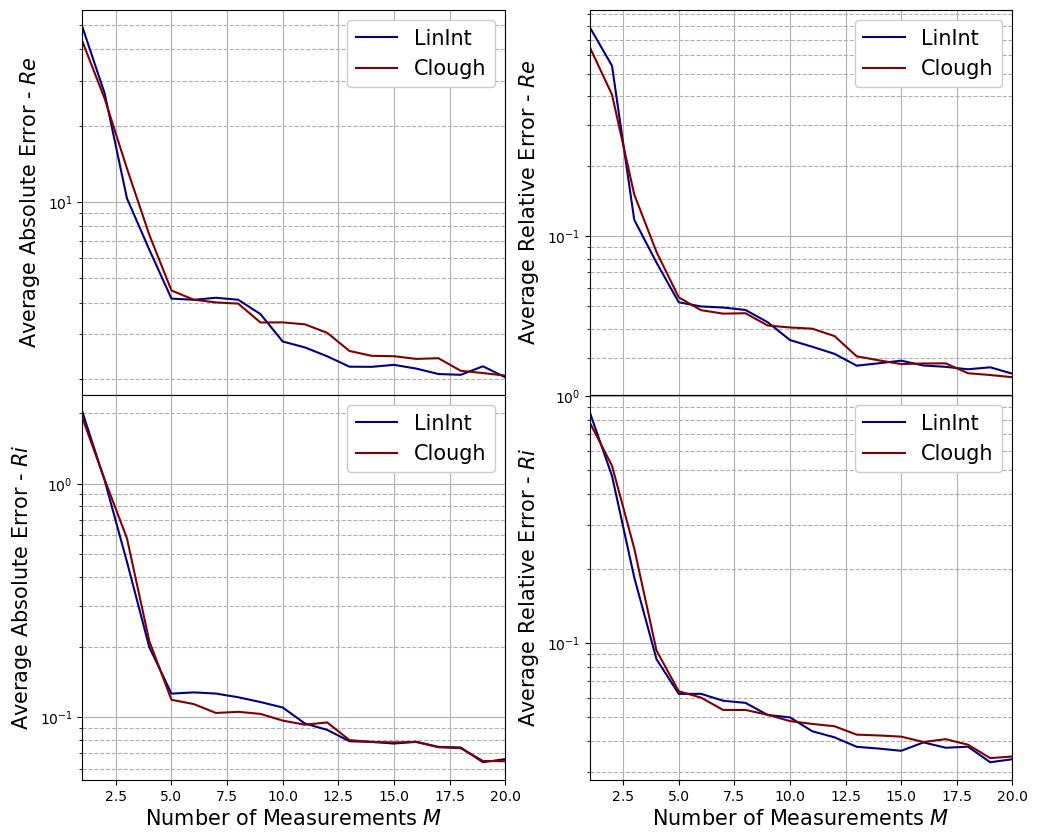

In [18]:
fig, axs = plt.subplots(nrows = mu_test.shape[1], ncols=2, sharex=True, figsize=(6 * 2, 5 * mu_test.shape[1]))

M_to_plot = np.arange(1, Mmax+1, 1)
parameters = [r'$Re$', r'$Ri$']

colors = cm.jet(np.linspace(0, 1, len(map_methods)))
for idx_mu in range(mu_test.shape[1]):
    for ii, map in enumerate(map_methods):
        axs[idx_mu, 0].semilogy(M_to_plot, ave_absErr_pe[map][:, idx_mu], c=colors[ii], label=map)
        axs[idx_mu, 1].semilogy(M_to_plot, ave_relErr_pe[map][:, idx_mu], c=colors[ii], label=map)
        
    for ax_i in range(2):
        axs[idx_mu, ax_i].grid(which='major',linestyle='-')
        axs[idx_mu, ax_i].grid(which='minor',linestyle='--')
        axs[idx_mu, ax_i].legend(framealpha=1, fontsize=15)
        axs[-1, ax_i].set_xlabel('Number of Measurements $M$', fontsize=15)
        axs[idx_mu, ax_i].set_xlim(1, Mmax)
    
    axs[idx_mu, 0].set_ylabel('Average Absolute Error - '+parameters[idx_mu], fontsize=15)
    axs[idx_mu, 1].set_ylabel('Average Relative Error - '+parameters[idx_mu], fontsize=15)

fig.subplots_adjust(hspace=0, wspace=0.2)

## Proper Orthogonal Decomposition with Interpolation (POD-I)

We are going to use the estimated parameter (using $M_{max}$ measures) to reconstruct the non-observable fields (pressure and velocity) using POD-I. This procedure is very similar to the case of Tutorial 1, in which the parameter was assumed to be known a priori and not determined by the measures.

In [19]:
from pyforce.online.pod_interpolation import PODI

podi_data = dict()
podi_res  = dict()

Nmax = 20

for field_i, field in enumerate(var_names):
    if field_i != obs_idx:
        podi_data[field] = dict()
        podi_res[field] = dict()

        bar = LoopProgress('POD-I '+field, final = len(map_methods))
        for map in map_methods:
            podi_data[field][map] = PODI(pod_modes[field], pod_maps[field][map], field)

            mu_star = np.array(mu_estimated[map])[:, Mmax-1, :]
            podi_res[field][map] = podi_data[field][map].synt_test_error(test_snaps[field], mu_star, Nmax)
            bar.update(1)
        del bar

POD-I p: 2.000 / 2.00 - 6.830 s/it
POD-I U: 2.000 / 2.00 - 7.696 s/it


Let us plot the mean absolute and relative errors for each field, respectively, defined as follows 
\begin{equation*}
\begin{split}
E_N[u] &= \left\langle \left\| u(\cdot;\,\boldsymbol{\mu}) - \mathcal{P}_N[u](\cdot;\,\boldsymbol{\mu})\right\|_{L^2(\Omega)}\right\rangle_{\boldsymbol{\mu}\in\Xi^{test}}\\
\varepsilon_N[u] &= \left\langle\frac{\left\| u(\cdot;\,\boldsymbol{\mu}) - \mathcal{P}_N[u](\cdot;\,\boldsymbol{\mu})\right\|_{L^2(\Omega)}}{\left\| u(\cdot;\,\boldsymbol{\mu}) \right\|_{L^2(\Omega)}}\right\rangle_{\boldsymbol{\mu}\in\Xi^{test}}
\end{split}
\end{equation*}
given $\mathcal{P}_N$ the reconstruction operator with $N$ basis functions.

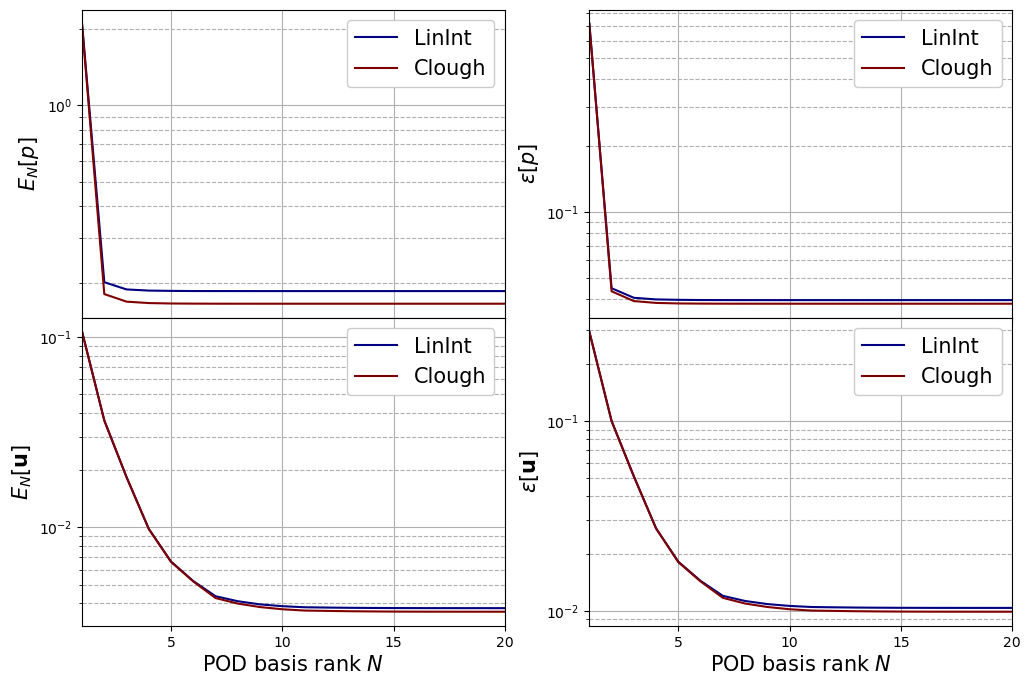

In [21]:
fig, axs = plt.subplots(nrows = len(var_names) - 1, ncols = 2, sharex=True, figsize=(6 * 2, 4 * (len(var_names) - 1)))

N_to_plot = np.arange(1, Nmax+1, 1)
colors = cm.jet(np.linspace(0, 1, len(map_methods)))
for field_i, field in enumerate(var_names):
    
    if field_i != obs_idx:
        for ax_i in range(2):
            for map_i, map in enumerate(map_methods):
                axs[field_i-1, ax_i].semilogy(N_to_plot, podi_res[field][map][ax_i], c=colors[map_i], label=map)
            axs[field_i-1, ax_i].legend(framealpha=1, fontsize=15)
            
            axs[field_i-1, ax_i].grid(which='major',linestyle='-')
            axs[field_i-1, ax_i].grid(which='minor',linestyle='--')
            axs[field_i-1, ax_i].set_xticks(np.arange(0, Nmax+1, 5))
            axs[field_i-1, ax_i].set_xlim(1, Nmax)
            
            axs[-1, ax_i].set_xlabel('POD basis rank $N$', fontsize=15)
            
        axs[field_i-1, 0].set_ylabel(r'$E_N['+tex_var_names[field_i]+']$', fontsize=15)
        axs[field_i-1, 1].set_ylabel(r'$\varepsilon['+tex_var_names[field_i]+']$', fontsize=15)
        
fig.subplots_adjust(hspace=0, wspace=0.2)

## Post Process

In this last section, we are going to plot the computational times and some contour plots of the non-observable fields.

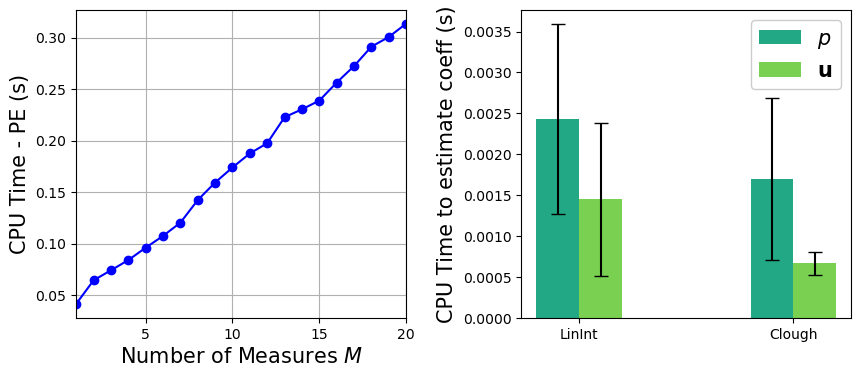

In [22]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(10,4))

axs[0].plot(M_to_plot, comput_times['LinInt']['Optimisation'].mean(axis=0), 'b-o')
axs[0].grid()
axs[0].set_xlim(1, Mmax)
axs[0].set_xlabel('Number of Measures $M$', fontsize=15)
axs[0].set_ylabel('CPU Time - PE (s)', fontsize=15)

# Iterate over field_i values
colors = plt.cm.viridis(np.linspace(0.4, 0.8, len(var_names)))  # Choose a colormap
for field_i, color in zip(range(len(var_names)), colors):
    
    if field_i != obs_idx:
        
        means = []
        stds = []

        # Calculate mean and std for each key
        for key in list(podi_res[var_names[field_i]].keys()):
            mean = np.mean(np.mean(podi_res[var_names[field_i]][key][2]['CoeffEstimation'], axis=0))
            std = np.std(np.mean(podi_res[var_names[field_i]][key][2]['CoeffEstimation'], axis=0))
            means.append(mean)
            stds.append(std)

        # Plot the bar chart with error bars for standard deviation
        bar_width = 0.2  # Adjust as needed
        ind = np.arange(len(list(podi_res[var_names[field_i]].keys())))
        bars = axs[1].bar(ind + (field_i - len(var_names) / 2) * bar_width, means, bar_width, label=r'$'+tex_var_names[field_i]+'$', color=color, yerr=stds, capsize=5)

        axs[1].set_ylabel(r'CPU Time to estimate coeff (s)', fontsize=15)
        axs[1].set_xticks(ind)
        axs[1].set_xticklabels(list(podi_res[var_names[field_i]].keys()))
        axs[1].legend(framealpha=1, fontsize=15)
        axs[1].grid()
        
fig.subplots_adjust(wspace=.35)

Lastly, we can plot the reconstructed fields for the non-observable variables using the `reconstruct` method of the `PODI` class.

In [23]:
Nmax = 15

reconstructions = dict()

for field_i, field in enumerate(var_names):
    
    if field_i != obs_idx:
        reconstructions[field] = dict()
        
        for key in map_methods:   
            reconstructions[field][key] = FunctionsList(fun_spaces[field_i])
            
        for mu in range(len(test_snaps[field])):
            
            for key in map_methods:
                mu_star = np.array(mu_estimated[map])[:, Mmax-1, :]
                reconstructions[field][key].append(podi_data[field][map].reconstruct(test_snaps[field](mu), mu_star[mu].reshape(-1,2), Nmax)[0])

In the end, let us make some contour plots of the reconstructed fields with POD-I, using the `plot_FOM_vs_ROM` from the `contour_plotting.py`.

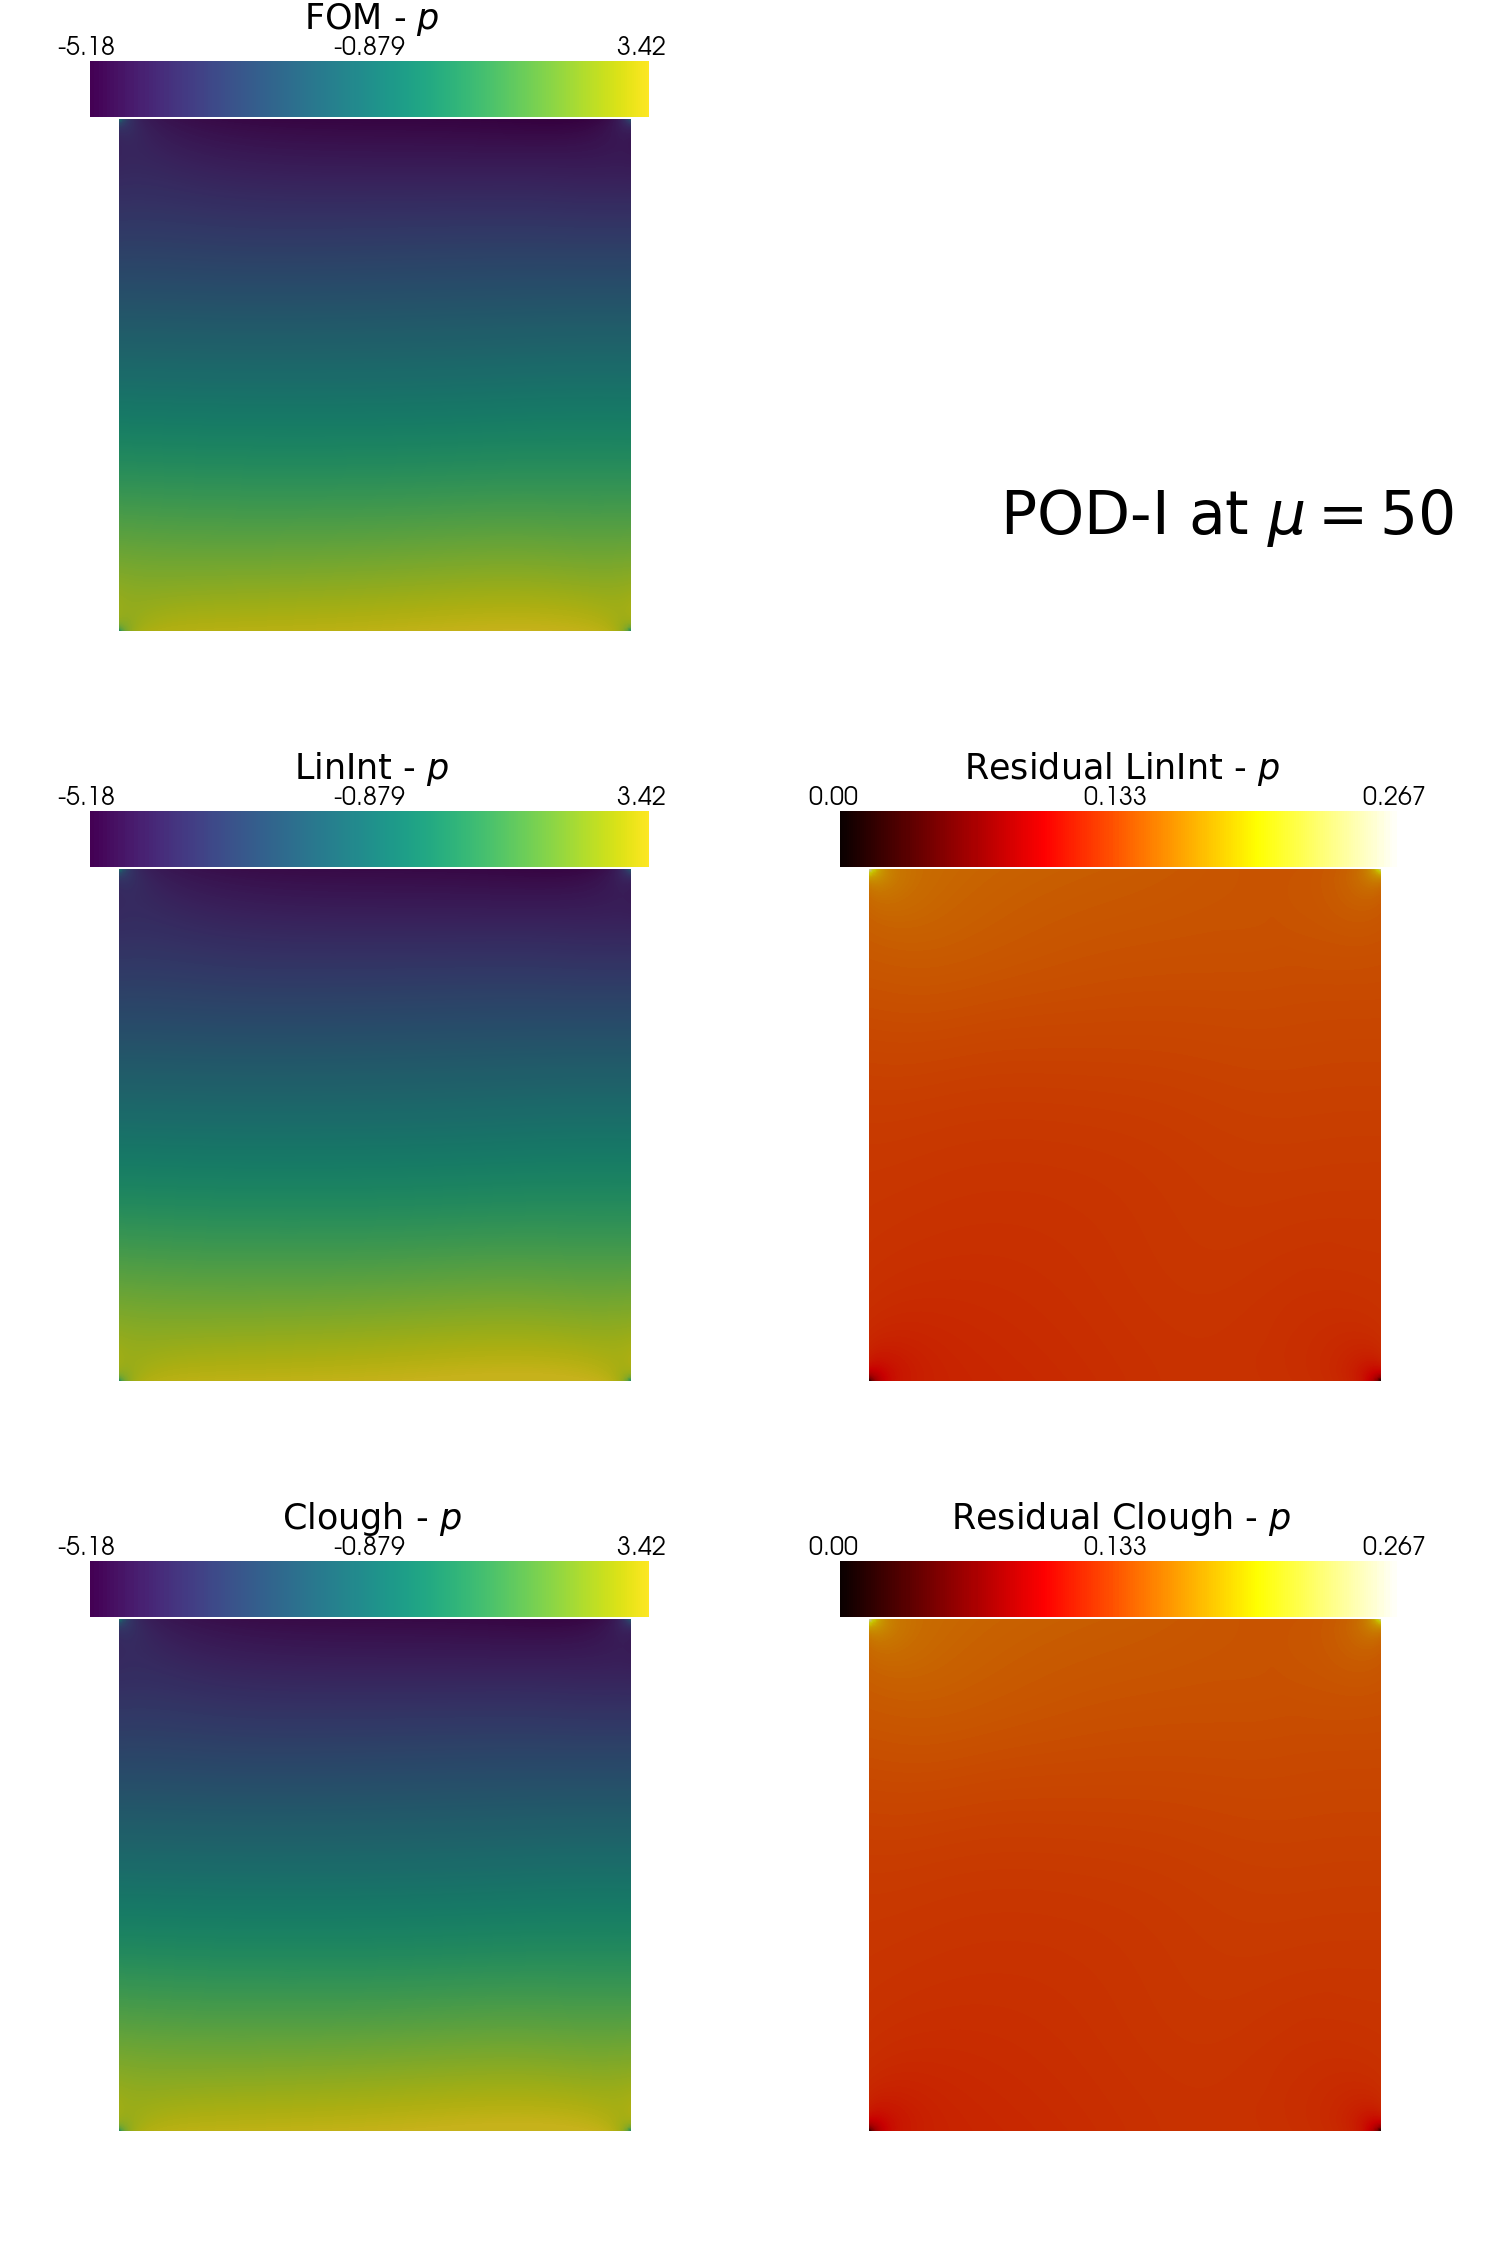

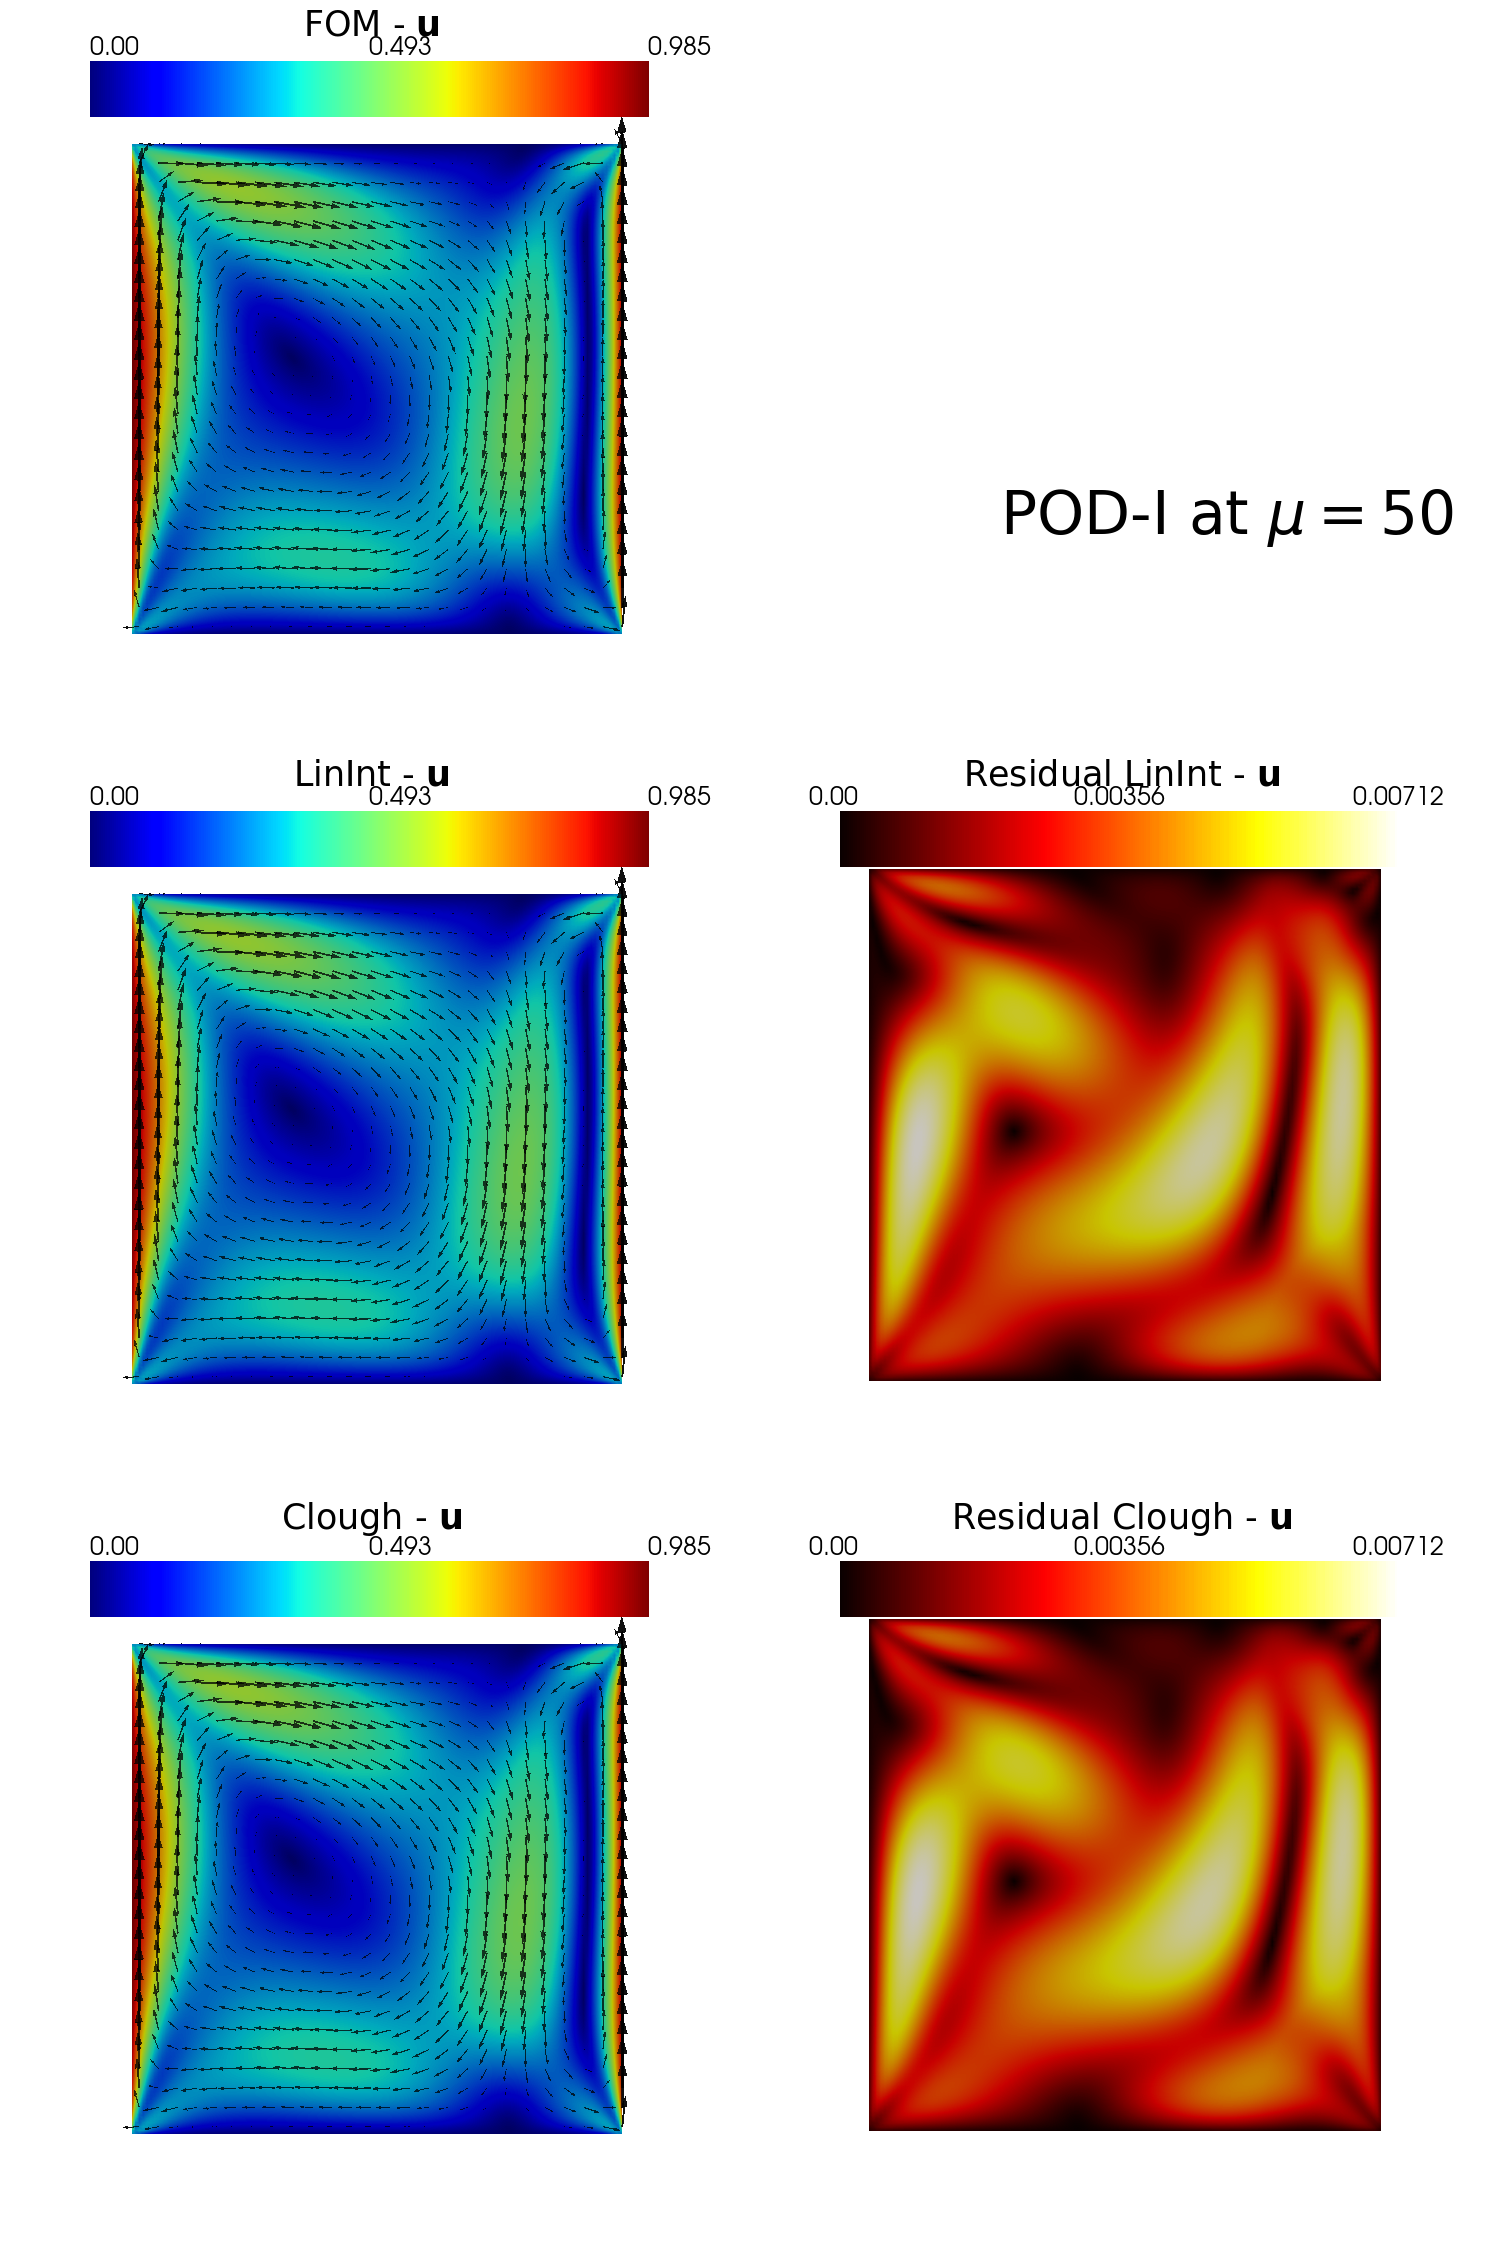

In [48]:
from contour_plotting import plot_FOM_vs_ROM

mu = 50

plot_FOM_vs_ROM(test_snaps[var_names[1]], reconstructions[var_names[1]], mu,
                title = 'POD-I at $\mu='+str(mu)+'$', varname=tex_var_names[1],
                _resolution = [750, 750], zoom = 1.,
                position_cb = [0.12, 0.843],
                colormap=cm.viridis, colormap_res=cm.hot)

plot_FOM_vs_ROM(test_snaps[var_names[2]], reconstructions[var_names[2]], mu,
                title = 'POD-I at $\mu='+str(mu)+'$', varname=tex_var_names[2],
                _resolution = [750, 750], zoom = 1.,
                position_cb = [0.12, 0.843],
                colormap=cm.jet, colormap_res=cm.hot,
                factor = 0.12, tolerance = 0.025, mag_plot=False)